In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt 
import torch

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F


from fase.nn.conv import *

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


In [3]:
num_workers = 0
batch_size = 32
valid_size = 0.2


## Scale 
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

train_data = datasets.CIFAR10('data', train=True,
                              download=True,
                              transform=transform
                             )
test_data = datasets.CIFAR10('data', train=False,
                             download=True, 
                             transform=transform
                            )

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import ResNet20

org_model = ResNet20.ResNet20(activation=F.relu)

In [14]:
import torchvision.transforms as transforms

img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]
n_batch, n_channel, nh, nw = img_tensor.shape

print(img_tensor.shape)

torch.Size([1, 3, 32, 32])


In [20]:
fn_param = "ResNet_20.pt"
trained_param = torch.load(fn_param)
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval()

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

In [16]:
org_model.eval()
data, target = next(iter(valid_loader))
out = org_model(data)

for oo, tt in zip(out, target):
    print(torch.argmax(oo),tt, torch.argmax(oo) == tt)

tensor(2) tensor(2) tensor(True)
tensor(9) tensor(9) tensor(True)
tensor(6) tensor(6) tensor(True)
tensor(8) tensor(8) tensor(True)
tensor(9) tensor(9) tensor(True)
tensor(6) tensor(6) tensor(True)
tensor(7) tensor(7) tensor(True)
tensor(4) tensor(4) tensor(True)
tensor(1) tensor(1) tensor(True)
tensor(1) tensor(1) tensor(True)
tensor(9) tensor(9) tensor(True)
tensor(4) tensor(4) tensor(True)
tensor(2) tensor(2) tensor(True)
tensor(4) tensor(4) tensor(True)
tensor(5) tensor(5) tensor(True)
tensor(0) tensor(0) tensor(True)
tensor(4) tensor(4) tensor(True)
tensor(4) tensor(4) tensor(True)
tensor(7) tensor(7) tensor(True)
tensor(2) tensor(2) tensor(True)
tensor(9) tensor(9) tensor(True)
tensor(3) tensor(3) tensor(True)
tensor(1) tensor(1) tensor(True)
tensor(3) tensor(3) tensor(True)
tensor(5) tensor(5) tensor(True)
tensor(3) tensor(3) tensor(True)
tensor(9) tensor(9) tensor(True)
tensor(5) tensor(5) tensor(True)
tensor(7) tensor(7) tensor(True)
tensor(4) tensor(4) tensor(True)
tensor(8) 

In [8]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

org_model(img_tensor) # == bird. Correct

tensor([[ -2.2855, -12.4620,  -0.1109,  -8.2943,  -8.1648, -10.4066,  -8.1414,
          -9.2153,  -6.1039,  -9.2975]], grad_fn=<LogSoftmaxBackward0>)

제대로 작동하는 것 확인 됨. 

이제 단계별 값 확인

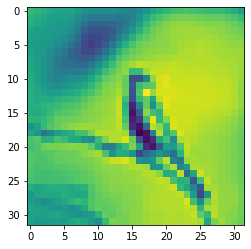

In [9]:
plt.imshow(img_tensor[0,0,:,:])

In [21]:
print(org_model.bn1.weight)
print(org_model.bn1.bias)
print(org_model.bn1.running_mean)
print(org_model.bn1.running_var)

Parameter containing:
tensor([0.4167, 0.5674, 0.5254, 0.4904, 0.4040, 0.6179, 0.6819, 0.5052, 0.6507,
        0.6042, 0.5120, 0.5347, 0.4702, 0.5840, 0.5745, 0.5341],
       requires_grad=True)
Parameter containing:
tensor([-0.1335,  0.0700,  0.5526,  0.2468,  0.7745, -0.1431,  0.1565,  0.1638,
        -0.1570,  0.6871, -0.1259,  0.2280,  0.5680,  0.6315, -0.0437,  0.5311],
       requires_grad=True)
tensor([ 0.0704,  0.0975, -0.0129, -0.2320, -0.0304, -0.1205, -0.2488,  0.0247,
         0.0958,  0.0092, -0.0702,  0.0783,  0.0499, -0.0231, -0.0906, -0.0539])
tensor([0.1392, 0.2570, 0.1766, 0.5015, 0.1291, 0.4963, 0.5788, 0.2135, 0.6493,
        0.2608, 0.4600, 0.4252, 0.3255, 0.6826, 0.2330, 0.4586])


In [17]:
# Conv1
tt0 = org_model.conv1(img_tensor)
print("1", tt0[0,3,12:18,12:18], tt0[0,3].shape)
tt1 = org_model.bn1(tt0)
print("2", tt1[0,3,12:18,12:18], tt1[0,3].shape)
tt2 = org_model.activation(tt1)
print("3", tt2[0,3,12:18,12:18], tt2[0,3].shape)

1 tensor([[ 1.0504,  1.0917,  1.0055,  0.1926,  0.4031,  0.5378],
        [ 1.0340,  1.0909,  0.9432,  0.1620,  0.3170,  0.2667],
        [ 1.0259,  1.1038,  0.8893,  0.1088,  0.2203,  0.2540],
        [ 1.0364,  1.1122,  0.9169,  0.1100,  0.1197,  0.4240],
        [ 1.0494,  1.1174,  0.9736,  0.1685,  0.0231,  0.3745],
        [ 1.0493,  1.1267,  1.0446,  0.2650, -0.0136,  0.0934]],
       grad_fn=<SliceBackward0>) torch.Size([32, 32])
2 tensor([[1.1349, 1.1635, 1.1038, 0.5408, 0.6866, 0.7799],
        [1.1235, 1.1630, 1.0607, 0.5197, 0.6270, 0.5921],
        [1.1179, 1.1719, 1.0233, 0.4828, 0.5600, 0.5833],
        [1.1252, 1.1777, 1.0425, 0.4836, 0.4903, 0.7011],
        [1.1342, 1.1813, 1.0817, 0.5242, 0.4234, 0.6668],
        [1.1341, 1.1878, 1.1309, 0.5910, 0.3981, 0.4721]],
       grad_fn=<SliceBackward0>) torch.Size([32, 32])
3 tensor([[1.1349, 1.1635, 1.1038, 0.5408, 0.6866, 0.7799],
        [1.1235, 1.1630, 1.0607, 0.5197, 0.6270, 0.5921],
        [1.1179, 1.1719, 1.0233, 0.4

In [45]:
out = F.batch_norm(tt1, 
                   org_model.bn1.running_mean, bb
                   org_model.bn1.running_var, 
                   org_model.bn1.weight,
                   org_model.bn1.bias,
                   False, 
                   0.1)

In [50]:
class MyBatchNorm2d(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-5, momentum=0.1,
                 affine=True, track_running_stats=True):
        super(MyBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)

    def forward(self, input):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3])
            # use biased var in train
            var = input.var([0, 2, 3], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = (input - mean[None, :, None, None]) / (torch.sqrt(var[None, :, None, None] + self.eps))
        if self.affine:
            input = input * self.weight[None, :, None, None] + self.bias[None, :, None, None]

        return input

In [53]:
mmb = MyBatchNorm2d(16)

In [132]:
mmb.running_mean = org_model.bn1.running_mean
mmb.running_var = org_model.bn1.running_var
mmb.weight = org_model.bn1.weight
mmb.bias = org_model.bn1.bias

In [139]:
print(tt0[0,3,12:18,12:18])
zz = mmb(tt0)

zz[0,3,12:18,12:18]

tensor([[ 1.0504,  1.0917,  1.0055,  0.1926,  0.4031,  0.5378],
        [ 1.0340,  1.0909,  0.9432,  0.1620,  0.3170,  0.2667],
        [ 1.0259,  1.1038,  0.8893,  0.1088,  0.2203,  0.2540],
        [ 1.0364,  1.1122,  0.9169,  0.1100,  0.1197,  0.4240],
        [ 1.0494,  1.1174,  0.9736,  0.1685,  0.0231,  0.3745],
        [ 1.0493,  1.1267,  1.0446,  0.2650, -0.0136,  0.0934]],
       grad_fn=<SliceBackward0>)


tensor([[1.1349, 1.1635, 1.1038, 0.5408, 0.6866, 0.7799],
        [1.1235, 1.1630, 1.0607, 0.5197, 0.6270, 0.5921],
        [1.1179, 1.1719, 1.0233, 0.4828, 0.5600, 0.5833],
        [1.1252, 1.1777, 1.0425, 0.4836, 0.4903, 0.7011],
        [1.1342, 1.1813, 1.0817, 0.5242, 0.4234, 0.6668],
        [1.1341, 1.1878, 1.1309, 0.5910, 0.3981, 0.4721]],
       grad_fn=<SliceBackward0>)

In [151]:
tt2[0,3,12:18,12:18]

tensor([[1.1349, 1.1635, 1.1038, 0.5408, 0.6866, 0.7799],
        [1.1235, 1.1630, 1.0607, 0.5197, 0.6270, 0.5921],
        [1.1179, 1.1719, 1.0233, 0.4828, 0.5600, 0.5833],
        [1.1252, 1.1777, 1.0425, 0.4836, 0.4903, 0.7011],
        [1.1342, 1.1813, 1.0817, 0.5242, 0.4234, 0.6668],
        [1.1341, 1.1878, 1.1309, 0.5910, 0.3981, 0.4721]],
       grad_fn=<SliceBackward0>)

In [152]:
ll11.conv1.weight

Parameter containing:
tensor([[[[ 1.6097e-02,  3.3110e-02,  7.5740e-02],
          [-3.9469e-02,  2.1580e-02,  2.2107e-02],
          [-1.1981e-02,  1.0342e-01,  1.1450e-01]],

         [[ 1.2720e-02, -5.1597e-02, -4.7466e-02],
          [-2.0413e-03,  1.0769e-02,  3.7019e-02],
          [ 4.6686e-02,  1.3379e-01,  1.4511e-01]],

         [[-1.2861e-01, -7.2780e-02, -1.2655e-01],
          [-1.8910e-01,  2.4692e-01,  1.1555e-02],
          [ 5.5489e-02, -1.5863e-01, -2.1765e-01]],

         ...,

         [[-8.7224e-02,  6.1674e-02,  1.5211e-01],
          [ 1.1667e-01,  1.4851e-01,  4.4324e-02],
          [-1.0227e-01,  1.7261e-01,  6.1332e-02]],

         [[ 6.2243e-02,  2.5469e-01,  9.4317e-02],
          [-6.0358e-02,  8.6461e-02,  9.1269e-02],
          [-9.7419e-02, -1.1660e-01,  5.8115e-02]],

         [[ 3.2906e-02, -1.7425e-02, -3.4924e-02],
          [-6.7983e-02,  1.0223e-01,  6.2429e-02],
          [ 7.0090e-02,  7.5114e-02,  1.3424e-03]]],


        [[[-5.1614e-02, -3.8458

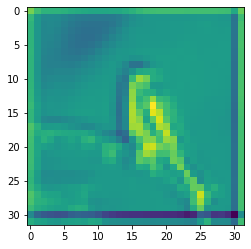

In [149]:
# layer1-1
ll11 = org_model.layer1._modules['0']

tt4 = ll11.conv1(tt2)
plt.imshow(tt4[0,3].detach().cpu())

In [150]:
print("4", tt4[0,3,12:18,12:18], tt4[0,3].shape)

4 tensor([[-1.4752, -2.0341, -1.8589, -0.2057, -0.8736, -1.0530],
        [-1.4893, -2.0867, -1.7438, -0.1942, -1.0180, -0.7687],
        [-1.5190, -2.1275, -1.6479, -0.0357, -0.8300, -0.6085],
        [-1.5402, -2.1481, -1.6701, -0.0155, -0.5195, -1.0606],
        [-1.5103, -2.1188, -1.6984, -0.0334, -0.2528, -1.2481],
        [-1.5070, -2.0801, -1.7340, -0.0946, -0.0685, -0.7609]],
       grad_fn=<SliceBackward0>) torch.Size([32, 32])


In [147]:
tt5 = ll11.bn1(tt4)
print("5", tt5[0,3,12:18,12:18], tt5[0,3].shape)
tt6 = ll11.activation(tt5)
print("6", tt6[0,3,12:18,12:18], tt6[0,3].shape)
tt7 = ll11.conv2(tt6)
print("7", tt7[0,3,12:18,12:18], tt7[0,3].shape)
tt8 = ll11.bn2(tt7)
print("8", tt8[0,3,12:18,12:18], tt8[0,3].shape)

tt9 = tt8 + tt2
print("9", tt9[0,3,12:18,12:18], tt9[0,3].shape)
tt10 = ll11.activation(tt9)
print("10", tt10[0,3,12:18,12:18], tt10[0,3].shape)

5 tensor([[-0.1892, -0.4258, -0.3517,  0.3482,  0.0655, -0.0105],
        [-0.1952, -0.4481, -0.3030,  0.3531,  0.0043,  0.1099],
        [-0.2077, -0.4654, -0.2624,  0.4202,  0.0839,  0.1777],
        [-0.2167, -0.4741, -0.2717,  0.4287,  0.2154, -0.0137],
        [-0.2041, -0.4617, -0.2837,  0.4211,  0.3283, -0.0931],
        [-0.2027, -0.4453, -0.2988,  0.3952,  0.4063,  0.1132]],
       grad_fn=<SliceBackward0>) torch.Size([32, 32])
6 tensor([[0.0000, 0.0000, 0.0000, 0.3482, 0.0655, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3531, 0.0043, 0.1099],
        [0.0000, 0.0000, 0.0000, 0.4202, 0.0839, 0.1777],
        [0.0000, 0.0000, 0.0000, 0.4287, 0.2154, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.4211, 0.3283, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.3952, 0.4063, 0.1132]],
       grad_fn=<SliceBackward0>) torch.Size([32, 32])
7 tensor([[-1.7274, -1.5217, -0.5743, -2.9900, -1.6750, -0.2602],
        [-1.7636, -1.3766, -0.7448, -2.5874, -1.4740, -1.0487],
        [-1.7695, -1.292

In [31]:
# layer1-2
ll12 = org_model.layer1._modules['1']

tt1 = ll12.conv1(tt)
tt1 = ll12.bn1(tt1)
tt1 = ll12.activation(tt1)
tt1 = ll12.conv1(tt)
tt1 = ll12.bn1(tt1)

tt1 = tt1 + tt
tt1 = ll12.activation(tt1)

1 tensor([-0.1964,  0.2486,  0.2336,  0.2163,  0.1935,  0.1819,  0.1850,  0.1802,
         0.1580,  0.1356,  0.1227,  0.1190,  0.1110,  0.1052,  0.0989,  0.0914,
         0.0932,  0.1179,  0.1544,  0.1905], grad_fn=<SliceBackward0>) torch.Size([32, 32])
2 tensor([-0.4315,  0.0654,  0.0487,  0.0294,  0.0039, -0.0091, -0.0056, -0.0109,
        -0.0357, -0.0607, -0.0752, -0.0792, -0.0883, -0.0947, -0.1018, -0.1102,
        -0.1082, -0.0805, -0.0398,  0.0006], grad_fn=<SliceBackward0>) torch.Size([32, 32])
3 tensor([0.0000, 0.0654, 0.0487, 0.0294, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0006], grad_fn=<SliceBackward0>) torch.Size([32, 32])
4 tensor([0.6576, 0.7646, 0.5695, 0.5572, 0.5694, 0.5820, 0.5678, 0.5511, 0.4982,
        0.4601, 0.4350, 0.4568, 0.4719, 0.4728, 0.4722, 0.5216, 0.5830, 0.6700,
        0.6962, 0.7269], grad_fn=<SliceBackward0>) torch.Size([32, 32])
5 tensor([-0.2577, -0.18